In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing

C:\Users\a1003\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\a1003\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\a1003\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Create the dataset

In [2]:
all_classes_names = os.listdir('C:/Users/a1003/OneDrive/桌面/IBM/neural_networks/data/UCF50')
all_classes_names

['BaseballPitch',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BreastStroke',
 'CleanAndJerk',
 'Diving',
 'Drumming',
 'Fencing',
 'GolfSwing',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'Nunchucks',
 'PizzaTossing',
 'PlayingGuitar',
 'PlayingPiano',
 'PlayingTabla',
 'PlayingViolin',
 'PoleVault',
 'PommelHorse',
 'PullUps',
 'Punch',
 'PushUps',
 'RockClimbingIndoor',
 'RopeClimbing',
 'Rowing',
 'SalsaSpin',
 'SkateBoarding',
 'Skiing',
 'Skijet',
 'SoccerJuggling',
 'Swing',
 'TaiChi',
 'TennisSwing',
 'test',
 'ThrowDiscus',
 'TrampolineJumping',
 'VolleyballSpiking',
 'WalkingWithDog',
 'YoYo']

### Select the intended sports and extract the intended video location

In [3]:
def intended_sports_video(sports_names, original_path):
    sports_names = sports_names
    capture_movements = []  
    L = []
    for name in sports_names:
        path = original_path + name  ### cd in to the intended sport folder
        capture_movment = os.listdir(path)  ### capture the movement video
        for sports_video_path in capture_movment:
            capture_movements.append(sports_video_path)
            L.append(name)
            
    return [capture_movements, L]

### Capture the frame of the intended video and create the corresponding sports name array

In [4]:
def frame_capture(cap_path, seq, resize_shape):
    cap_path = cap_path
    seq = seq
    resize_shape = resize_shape
    sports_lists = []
    vidcap = cv2.VideoCapture(cap_path) ### capture the frame
    for frame_counter in range(seq):  
        video_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames/seq), 1)
        vidcap.set(cv2.CAP_PROP_FRAME_COUNT, int(frame_counter*skip_frames_window*1.5)) ### set the frame position
        success, image = vidcap.read()
        if not success:
            break
        rgb_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ### to RGB
        rgb_frame_resize = cv2.resize(rgb_frame, (60,80)) ### resize
        rgb_frame_resize = rgb_frame_resize/255 ### nornalization 
        
        sports_lists.append(rgb_frame_resize)
    vidcap.release()
    return sports_lists

In [5]:
def sports_video_frame_capture(capture_movements, Labels, original_path, seq, resize_shape):
    sports_frames = []
    sports_labels = []
    for movement, label in zip(capture_movements, Labels):
        cap_path = original_path + str(label) + '/' + str(movement)  ### locate the folder diractory
        seq = seq
        resize_shape = resize_shape
        f = frame_capture(cap_path, seq, resize_shape)
        if len(f) == seq:
            sports_frames.append(f)
            sports_labels.append(label)



    sports_frames = np.asarray(sports_frames)
    sports_labels = np.array(sports_labels)
    print('Collected_frame (observations, frames_sequence_length, image(width), image(height), RGB): '  + str(sports_frames.shape) + '\n' + 
          'Sports_label: ' + str(np.unique(sports_labels)) + '\n' + 
          'Number of collected videos: ' + str(len(capture_movements))
         )
    
    return [sports_frames, sports_labels]

### Target the recognized sports

In [40]:
sports_names = [ 'BenchPress','PullUps', 'PushUps'] ### choose sport
original_path = 'C:/Users/a1003/OneDrive/桌面/IBM/neural_networks/data/UCF50/' ### set path
capture_movements, Labels = intended_sports_video(sports_names, original_path)
capture_movements = capture_movements
Labels = Labels
resize_shape = (60,80)
seq = 20
inputs, targets = sports_video_frame_capture(capture_movements, Labels, original_path, seq, resize_shape)

Collected_frame (observations, frames_sequence_length, image(width), image(height), RGB): (387, 20, 80, 60, 3)
Sports_label: ['BenchPress' 'PullUps' 'PushUps']
Number of collected videos: 387


In [22]:
test_sports_names = ['test']
test_original_path = 'C:/Users/a1003/OneDrive/桌面/IBM/neural_networks/data/UCF50/'
test_capture_movements, test_Labels = intended_sports_video(test_sports_names, original_path)
capture_movements = test_capture_movements
Labels = test_Labels
resize_shape = (60,80)
seq = 20
test_inputs, test_targets = sports_video_frame_capture(capture_movements, Labels, test_original_path, seq, resize_shape)

Collected_frame (observations, frames_sequence_length, image(width), image(height), RGB): (1, 20, 80, 60, 3)
Sports_label: ['test']
Number of collected videos: 1


Text(0.5, 1.0, 'test')

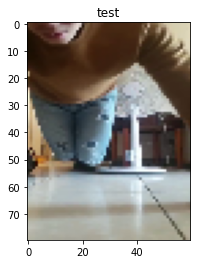

In [33]:
plt.imshow(test_inputs[0,10,:,:,:])
plt.title(test_targets[0])

Text(0.5, 1.0, 'BenchPress')

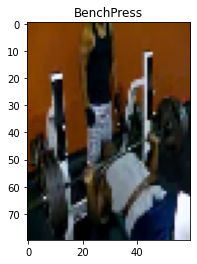

In [7]:
plt.imshow(inputs[15,15,:,:])
plt.title(test_targets[15])

## Train_Test_Split the videos

In [8]:
label_transform = preprocessing.LabelEncoder()
label_transform.fit(targets)
int_targets = label_transform.transform(targets)

In [9]:
one_hot_targets = tf.keras.utils.to_categorical(int_targets)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(inputs, one_hot_targets, test_size = 0.2, random_state = 42, shuffle = 1)

## Model constructing

#### First variation

In [11]:
model_1 = tf.keras.Sequential()

    # Define the Model Architecture.
########################################################################################################################

model_1.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True, input_shape = (inputs.shape[1],
                                                                                  inputs.shape[2], inputs.shape[3], 3)))

model_1.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_1.add(tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_1.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_1.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_1.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_1.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_1.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_1.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#model.add(TimeDistributed(Dropout(0.2)))

model_1.add(tf.keras.layers.Flatten()) 

model_1.add(tf.keras.layers.Dense(len(sports_names), activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 78, 58, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 39, 29, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 39, 29, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 37, 27, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 19, 14, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 19, 14, 8)     0         
_________________________________________

In [12]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

#### Second variation (reduce one layer)

In [13]:
model_2 = tf.keras.Sequential()

    # Define the Model Architecture.
########################################################################################################################

model_2.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True, input_shape = (inputs.shape[1],
                                                                                  inputs.shape[2], inputs.shape[3], 3)))



model_2.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_2.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_2.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_2.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_2.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_2.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#model.add(TimeDistributed(Dropout(0.2)))

model_2.add(tf.keras.layers.Flatten()) 

model_2.add(tf.keras.layers.Dense(len(sports_names), activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 20, 78, 58, 4)     1024      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 20, 39, 29, 4)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 39, 29, 4)     0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 20, 37, 27, 14)    9128      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 20, 19, 14, 14)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 19, 14, 14)    0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 20, 17, 12, 16)   

In [14]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

#### Third variation (reduce one layer and change the kernal number from 4 to 10 and size from (3, 3) to (2, 2))

In [15]:
model_3 = tf.keras.Sequential()

    # Define the Model Architecture.
########################################################################################################################

model_3.add(tf.keras.layers.ConvLSTM2D(filters = 5, kernel_size = (2, 2), activation = 'tanh',data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True, input_shape = (inputs.shape[1],
                                                                                  inputs.shape[2], inputs.shape[3], 3)))



model_3.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_3.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_3.add(tf.keras.layers.ConvLSTM2D(filters = 5, kernel_size = (2, 2), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_3.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model_3.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

model_3.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model_3.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#model_3.add(TimeDistributed(Dropout(0.2)))

model_3.add(tf.keras.layers.Flatten()) 

model_3.add(tf.keras.layers.Dense(len(sports_names), activation = "softmax"))

########################################################################################################################

# Display the models summary.
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 20, 79, 59, 5)     660       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 20, 40, 30, 5)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 40, 30, 5)     0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 20, 39, 29, 5)     820       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 20, 20, 15, 5)     0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 20, 15, 5)     0         
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 20, 18, 13, 16)   

In [16]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

## Train and test the model

#### variation 1

In [17]:
# Start training the model.
convlstm_model_training_history = model_1.fit(x = x_train, y = y_train, epochs = 15, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 246 samples, validate on 62 samples
Epoch 1/15
246/246 [==============================] - 97s 394ms/sample - loss: 1.1035 - acc: 0.3537 - val_loss: 1.0801 - val_acc: 0.4032
Epoch 2/15
246/246 [==============================] - 95s 387ms/sample - loss: 1.0748 - acc: 0.4309 - val_loss: 1.0429 - val_acc: 0.5000
Epoch 3/15
246/246 [==============================] - 98s 397ms/sample - loss: 0.9714 - acc: 0.5691 - val_loss: 0.7251 - val_acc: 0.6935
Epoch 4/15
246/246 [==============================] - 95s 384ms/sample - loss: 0.7307 - acc: 0.6626 - val_loss: 0.4695 - val_acc: 0.8710
Epoch 5/15
246/246 [==============================] - 95s 385ms/sample - loss: 0.5457 - acc: 0.7683 - val_loss: 0.4375 - val_acc: 0.8548
Epoch 6/15
246/246 [==============================] - 95s 387ms/sample - loss: 0.3361 - acc: 0.8699 - val_loss: 0.2142 - val_acc: 0.9355
Epoch 7/15
246/246 [===================

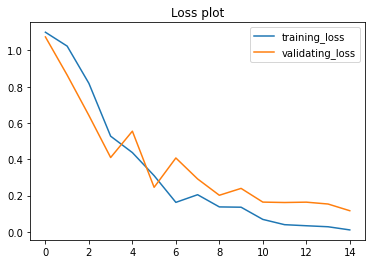

In [16]:
plt.plot(range(15), convlstm_model_training_history.history['loss'], label = 'training_loss')
plt.plot(range(15), convlstm_model_training_history.history['val_loss'], label = 'validating_loss')
plt.title('Loss plot')
plt.legend()

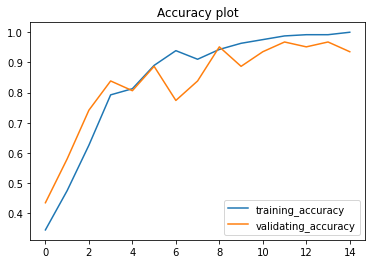

In [17]:
plt.plot(range(15), convlstm_model_training_history.history['acc'], label = 'training_accuracy')
plt.plot(range(15), convlstm_model_training_history.history['val_acc'], label = 'validating_accuracy')
plt.title('Accuracy plot')
plt.legend()

In [19]:
prediction = model_1.predict(x_test)

In [24]:
y_prediction = np.argmax(prediction, axis=1)

In [25]:
y_prediction

array([2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 2, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2, 0, 0,
       0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0], dtype=int64)

In [27]:
y_test = np.argmax(y_test, axis=1)

In [29]:
from sklearn.metrics import accuracy_score
testing_accuracy = accuracy_score(y_test, y_prediction)

print("Testing accuracy is: " + str(testing_accuracy))

Testing accuracy is: 0.9102564102564102


#### variation 2

In [32]:
# Start training the model.
convlstm_model_training_history_2 = model_2.fit(x = x_train, y = y_train, epochs = 15, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Train on 246 samples, validate on 62 samples
Epoch 1/15
246/246 [==============================] - 107s 434ms/sample - loss: 1.0605 - acc: 0.4146 - val_loss: 0.9206 - val_acc: 0.5968
Epoch 2/15
246/246 [==============================] - 107s 433ms/sample - loss: 0.7390 - acc: 0.7195 - val_loss: 1.1237 - val_acc: 0.6774
Epoch 3/15
246/246 [==============================] - 106s 430ms/sample - loss: 0.6049 - acc: 0.7724 - val_loss: 0.6605 - val_acc: 0.7419
Epoch 4/15
246/246 [==============================] - 107s 435ms/sample - loss: 0.3238 - acc: 0.8821 - val_loss: 0.8906 - val_acc: 0.6290
Epoch 5/15
246/246 [==============================] - 108s 438ms/sample - loss: 0.1224 - acc: 0.9593 - val_loss: 0.4248 - val_acc: 0.8226
Epoch 6/15
246/246 [==============================] - 107s 436ms/sample - loss: 0.1201 - acc: 0.9715 - val_loss: 0.2410 - val_acc: 0.9032
Epoch 7/15
246/246 [==============================] - 106s 431ms/sample - loss: 0.0358 - acc: 0.9919 - val_loss: 0.0989 - val_a

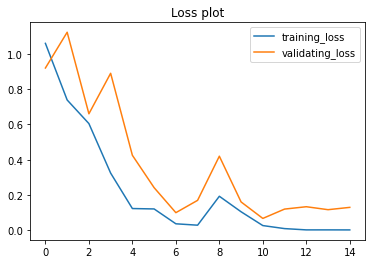

In [33]:
plt.plot(range(15), convlstm_model_training_history_2.history['loss'], label = 'training_loss')
plt.plot(range(15), convlstm_model_training_history_2.history['val_loss'], label = 'validating_loss')
plt.title('Loss plot')
plt.legend()

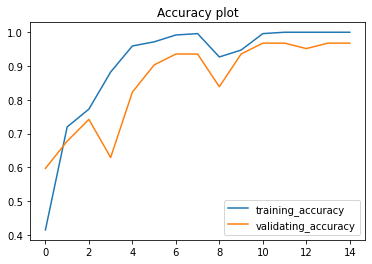

In [36]:
plt.plot(range(15), convlstm_model_training_history_2.history['acc'], label = 'training_accuracy')
plt.plot(range(15), convlstm_model_training_history_2.history['val_acc'], label = 'validating_accuracy')
plt.title('Accuracy plot')
plt.legend()

In [52]:
prediction = model_2.predict(x_test)

In [53]:
y_prediction = np.argmax(prediction, axis=1)

In [54]:
#y_test = np.argmax(y_test, axis=1)

In [55]:
from sklearn.metrics import accuracy_score
testing_accuracy = accuracy_score(y_test, y_prediction)

print("Testing accuracy is: " + str(testing_accuracy))

Testing accuracy is: 1.0


#### variation 3

In [44]:
# Start training the model.
convlstm_model_training_history_3 = model_3.fit(x = x_train, y = y_train, epochs = 15, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Train on 246 samples, validate on 62 samples
Epoch 1/15
246/246 [==============================] - 113s 459ms/sample - loss: 1.1365 - acc: 0.3821 - val_loss: 0.9951 - val_acc: 0.7258
Epoch 2/15
246/246 [==============================] - 119s 483ms/sample - loss: 0.9601 - acc: 0.5325 - val_loss: 0.9535 - val_acc: 0.5968
Epoch 3/15
246/246 [==============================] - 120s 487ms/sample - loss: 0.6891 - acc: 0.7236 - val_loss: 0.7870 - val_acc: 0.6452
Epoch 4/15
246/246 [==============================] - 119s 484ms/sample - loss: 0.3856 - acc: 0.8374 - val_loss: 0.6704 - val_acc: 0.7419
Epoch 5/15
246/246 [==============================] - 118s 479ms/sample - loss: 0.2001 - acc: 0.9268 - val_loss: 0.3092 - val_acc: 0.8710
Epoch 6/15
246/246 [==============================] - 120s 486ms/sample - loss: 0.1269 - acc: 0.9593 - val_loss: 1.6093 - val_acc: 0.5968
Epoch 7/15
246/246 [==============================] - 119s 482ms/sample - loss: 0.1213 - acc: 0.9472 - val_loss: 0.4196 - val_a

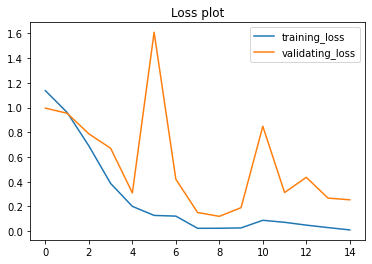

In [46]:
plt.plot(range(15), convlstm_model_training_history_3.history['loss'], label = 'training_loss')
plt.plot(range(15), convlstm_model_training_history_3.history['val_loss'], label = 'validating_loss')
plt.title('Loss plot')
plt.legend()

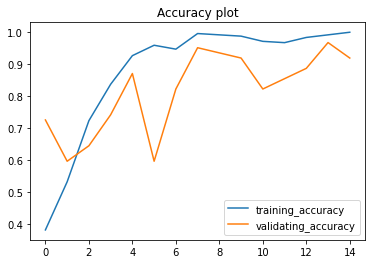

In [47]:
plt.plot(range(15), convlstm_model_training_history_3.history['acc'], label = 'training_accuracy')
plt.plot(range(15), convlstm_model_training_history_3.history['val_acc'], label = 'validating_accuracy')
plt.title('Accuracy plot')
plt.legend()

In [48]:
prediction = model_3.predict(x_test)

In [49]:
y_prediction = np.argmax(prediction, axis=1)

In [50]:
#y_test = np.argmax(y_test, axis=1)

In [51]:
from sklearn.metrics import accuracy_score
testing_accuracy = accuracy_score(y_test, y_prediction)

print("Testing accuracy is: " + str(testing_accuracy))

Testing accuracy is: 0.9230769230769231
